This should be able to plot the lund plane (z, theta) as a contour plot. The full expression, the fraction and the error.
Also plot anything in 2d as a function of time, z and theta, with error bands.
Full, large-Nc, hom and eikonal solutions

In [418]:
import matplotlib.pyplot as plt
from matplotlib import ticker, cm
import matplotlib.colors as mcolors
from functions import *

In [419]:
# These are the parameters for the case I want to analyze, which are not necessarily the same as those I generate

qhatmix=1.5 #GeV^2/fm
q=qhatmix*25.77 #fm^(-3)
EGev = 10 # Energy in Gev
E = EGev * 5.076 # Conversion factor to fm^-1
#z=0.4

Nc=3
CF=(Nc**2-1)/(2*Nc)

#a=lambda z: np.sqrt(q/w)
#Ou=(1-1j)/2*a
#Ov=(1+1j)/2*a

# Numerical parameters
ma=2 # This is the grid size in fm
u1max=ma
u2max=ma
v1max=ma
v2max=ma
u1min=-u1max
u2min=-u2max
v1min=-v1max
v2min=-v2max
#tmax=1e-2
t0=0
tmax=2 # Maximum medium length in fm


N=50 # Number of grid points. Should be at least 40 for okay results, ideally more
Nu1 = N
Nu2 = N
Nv1 = N
Nv2 = N


du1 = (u1max-u1min)/(Nu1-1)
du2 = (u2max-u2min)/(Nu2-1)
dv1 = (v1max-v1min)/(Nv1-1)
dv2 = (v2max-v2min)/(Nv2-1)
hu1,hu2,hv1,hv2 = int(Nu1/2),int(Nu2/2),int(Nv1/2),int(Nv2/2)

dtdusq=0.5

deltat=dtdusq*du1**2
Nt=round((tmax-t0)/deltat) # The number of time points is decided by the griz size and number of grid points
#Nt=round(Nt/10)*10

dt = (tmax-t0)/(Nt-1)
t = np.linspace(t0, tmax, Nt)

In [447]:
points = 10

lower_th = 0.01
upper_th = 0.5 
log_oneover_th = np.linspace(np.log(1/lower_th),np.log(1/upper_th),points)
theta_values = np.exp(-log_oneover_th)
print(log_oneover_th)

dth = log_oneover_th[0]-log_oneover_th[1]
log_oneover_th_extended = np.array([log_oneover_th[points-1]-dth,log_oneover_th[points-1]-2*dth,log_oneover_th[points-1]-3*dth])
print(log_oneover_th_extended)
theta_values_extended = np.exp(-log_oneover_th_extended)
print(theta_values_extended)

[4.60517019 4.17050096 3.73583174 3.30116252 2.86649329 2.43182407
 1.99715485 1.56248563 1.1278164  0.69314718]
[ 0.25847796 -0.17619127 -0.61086049]
[0.77222605 1.19266615 1.84201575]


In [420]:

def w(z):
    return E*z*(1-z)

def O(z):
    return (1-1j)/2*np.sqrt(q/w(z))

def eik2(t,L,z,th):
    pre = 4*w(z)**2/(q*(1-2*z*1*(1-z))*t**2)
    exp1 = -1j*th**2*w(z)*t/2
    exp2=-q*th**2*t**3/12
    exp3=-q*th**2*(1-2*z*1*(1-z))*(L-t)*t**2/4
    return pre*np.exp(exp1)*np.exp(exp2)*(1-np.exp(exp3))

def eik2int(L,z,th):
    def real_fas(t,L,z,th):
        return np.real(eik2(t,L,z,th))
    def imag_fas(t,L,z,th):
        return np.imag(eik2(t,L,z,th))
    re = quad(real_fas,0,L,args=(L,z,th))[0]
    im = quad(imag_fas,0,L,args=(L,z,th))[0]

    return re + 1j*im

def fasit2Ncdiag(t,L,p1,p2,z):
    pre= -2*1j*w(z)
    
    num = 2*w(z)*O(z)/np.tan(O(z)*t)
    den = 2*w(z)*O(z)/np.tan(O(z)*t)+1j*q*(z**2+(1-z)**2)*(L-t)
    
    return pre*(1-num/den*np.exp(-1j*(p1**2+p2**2)/den))

def fasit2Ncdiagint(L,p1,p2,z):
    def real_fas(t,L,p1,p2,z):
        return np.real(fasit2Ncdiag(t,L,p1,p2,z))
    def imag_fas(t,L,p1,p2,z):
        return np.imag(fasit2Ncdiag(t,L,p1,p2,z))
    re = quad(real_fas,0,L,args=(L,p1,p2,z))[0]
    im = quad(imag_fas,0,L,args=(L,p1,p2,z))[0]

    return re + 1j*im


In [421]:
points = 10
lower_z = 0.01
upper_z = 0.5
log_oneover_z = np.linspace(np.log(1/lower_z),np.log(1/upper_z),points)
# Make grid smaller if we want
log_oneover_z = log_oneover_z[0:points]
z_values = np.exp(-log_oneover_z)

# Use theta as proxy for p, as p ~ z*(1-z)*th*E
lower_th = 0.01
upper_th = 0.5 
log_oneover_th = np.linspace(np.log(1/lower_th),np.log(1/upper_th),points)
log_oneover_th = log_oneover_th[0:points]
theta_values = np.exp(-log_oneover_th)

th_points = len(theta_values)
z_points = len(z_values)

Z, TH = np.meshgrid(log_oneover_z,log_oneover_th)

In [422]:
def Fp(time_frac):
    time_n = int(len(t)*time_frac)-1

    Fp_full = np.zeros([th_points,z_points])
    Fp_Nc = np.zeros([th_points,z_points])
    Fp_diag = np.zeros([th_points,z_points])
    Fp_diag_true = np.zeros([th_points,z_points])

    for i,theta in enumerate(theta_values):
        for j,z in enumerate(z_values):

            all = np.load(f'{filename}_theta={theta:.3f}_z={z:.3f}_L={tmax}_E={EGev}_gridpoints={N}_gridsize={grid_size}.npy')

            full2 = all[2]
            Nc2 = all[4]
            diag2 = all[6]
            diag2_fasit = all[8]

            Fp_full[i,j] = np.real(full2[time_n])
            Fp_Nc[i,j] = np.real(Nc2[time_n])
            Fp_diag[i,j] = np.real(diag2[time_n])
            Fp_diag_true[i,j] = np.real(diag2_fasit[time_n])
        
    return  Fp_full,Fp_Nc,Fp_diag,Fp_diag_true


In [423]:
def Fmed_inout(z,th,t):
    ex = -1j*np.tan(O(z)*t)*w(z)*th**2/(2*O(z))
    return -2*np.real(1-np.exp(ex))

In [424]:
def Fmed(time_frac):
    time_n = int(len(t)*time_frac)-1
    time = t[time_n]

    inin_full = np.zeros([th_points,z_points])
    inin_Nc = np.zeros([th_points,z_points])   
    inin_diag = np.zeros([th_points,z_points])
    inin_diag_true = np.zeros([th_points,z_points])
    inout_full = np.zeros([th_points,z_points])


    for i,theta in enumerate(theta_values):
        for j,z in enumerate(z_values):

            all = np.load(f'{filename}_theta={theta:.3f}_z={z:.3f}_L={tmax}_E={EGev}_gridpoints={N}_gridsize={grid_size}.npy')

            full2 = all[2]
            Nc2 = all[4]
            diag2 = all[6]
            diag2_fasit = all[8]

            inin_full[i,j] = theta**2/2*np.real(full2[time_n])
            inin_Nc[i,j] = theta**2/2*np.real(Nc2[time_n])
            inin_diag[i,j] = theta**2/2*np.real(diag2[time_n])
            inin_diag_true[i,j] = theta**2/2*np.real(diag2_fasit[time_n])

            inout_full[i,j] = Fmed_inout(z,theta,time)

    Fmed_full = inin_full + inout_full
    Fmed_Nc = inin_Nc + inout_full
    Fmed_diag = inin_diag + inout_full
    Fmed_diag_true = inin_diag_true + inout_full


    return Fmed_full,Fmed_Nc,Fmed_diag,Fmed_diag_true



In [425]:
def get_ticks(z,c,n):
    ma=np.max(z)
    mi=np.min(z)
    
    step=(ma-mi)/(n-1)
    psteps=round((ma-c)/step)
    msteps=round((c-mi)/step)
    
    ma_n = c+psteps*step
    mi_n = c-msteps*step
    ticks=np.linspace(mi_n,ma_n,n)
    lines=np.linspace(mi_n-step/2,ma_n+step/2,n+1)
    
    return ticks, lines


In [426]:
def pl(zvalues,cent,time,name=0,log = False,ticks=0):

    plt.rcParams['text.usetex'] = True

    fig = plt.figure(figsize=(8,6))
    left, bottom, width, height = 0.1, 0.1, 0.8, 0.8
    ax = fig.add_axes([left, bottom, width, height]) 

    plt.tick_params(axis='both',which='both', right=True, top=True, bottom=True, direction='in', labelsize=18)

    if log:
        from matplotlib.colors import LogNorm
        levels = np.logspace(-4,2,13)
        cp = plt.contourf(TH,Z,zvalues,levels=levels,cmap=plt.get_cmap('YlOrRd'),norm = LogNorm())

        def fmt(x, pos):
            a, b = '{:.0e}'.format(x).split('e')
            b = int(b)
            return r'$ 10^{{{}}}$'.format(b)

        '''def fmt(x, pos):
            a, b = '{:.0e}'.format(x).split('e')
            b = int(b)
            return r'${} \times 10^{{{}}}$'.format(a, b)'''

        cbar = plt.colorbar(cp, format=ticker.FuncFormatter(fmt))
        cbar.ax.tick_params(labelsize=18)

    else:
        num = 9
        ticks,lines = get_ticks(zvalues,cent,num)

        if abs(cent-lines[0]) < abs(cent-lines[num]):
            cmax = lines[num]
            cmin = 2*cent-cmax
        else:
            cmin = lines[0]
            cmax = 2*cent-cmin
        

        cp = plt.contourf(TH, Z,zvalues,levels=lines,vmin=cmin,vmax = cmax,cmap=plt.get_cmap('RdBu_r'))
        cbar = plt.colorbar(ticks=ticks)
        cbar.ax.tick_params(labelsize=18)
        

    ax.set_title(r'$\hat{q}=%.1f\,\mathrm{GeV}^2/\mathrm{fm},\, L = %.2f\,\mathrm{fm},\,E = %.0f\,\mathrm{GeV}$'% (qhatmix,time,EGev),fontsize=14)

    #ax.text(1.3,np.max(log_oneover_z)-0.25,r'$\hat{q}=%.1f\,\mathrm{GeV}^2/\mathrm{fm},\, L = %.2f\,\mathrm{fm},\,E = %.0f\,\mathrm{GeV}$'% (qhatmix,time,EGev),fontsize = 13)


    ax.set_xlabel(r'$\log 1/ \theta$', fontsize=20)
    ax.set_ylabel(r'$\log 1/z$', fontsize=20)
    
    if name !=0:
        plt.savefig(f'plots/{name}_{EGev}.png', bbox_inches='tight')
    
    plt.show()

In [427]:
def time_plot(z_n,theta_n,Fmed=False):
    theta = theta_values[theta_n]
    z = z_values[z_n]

    all = np.load(f'{filename}_theta={theta:.3f}_z={z:.3f}_L={tmax}_E={EGev}_gridpoints={N}_gridsize={grid_size}.npy')
    full2 = all[2]
    Nc2 = all[4]
    diag2 = all[6]
    diag2_fasit = all[8]

    eik = t.copy()
    for i in range(1,len(t)):
        eik[i] = np.real(eik2int(t[i],z,theta))
    
    if Fmed:
        inout = Fmed_inout(z,theta,t)

        full2 = theta**2/2*np.real(full2)+inout
        Nc2 = theta**2/2*np.real(Nc2)+inout
        diag2 = theta**2/2*np.real(diag2)+inout
        diag2_fasit = theta**2/2*np.real(diag2_fasit) + inout

        eik = theta**2/2*eik + inout

    error = np.abs(np.real(diag2)-np.real(diag2_fasit))

    plt.rcParams['text.usetex'] = True


    plt.plot(t,np.real(full2), label=r'Numeric $N_c=3$')
    plt.fill_between(t, np.real(full2)-error, np.real(full2)+error, alpha=.3)
    plt.plot(t,np.real(Nc2), label=r'Numeric large-$N_c$')
    #plt.plot(t,np.real(diag2), label='K2 Numeric-diag-re')
    plt.plot(t,np.real(diag2_fasit), label=r'Analytic large-$N_c$ hom')

    plt.plot(t,eik, label=r'Analytic large-$N_c$ and eikonal hom')

    plt.xlabel(r'$\mathrm{time\,[fm]}$',fontsize =12)
    if Fmed:
        plt.ylabel(r'$F_{\mathrm{med}}$',fontsize =12)
    else:
        plt.ylabel(r'$F(\mathbf{p})$',fontsize =12)
    plt.title(r'$\hat{q}=%.1f\,\mathrm{GeV}^2/\mathrm{fm},\, \theta = %.2f,\,z=%.2f,\,E = %.0f\,\mathrm{GeV}$'% (qhatmix,theta,z,EGev),fontsize=14)


    plt.legend(loc="lower left")
    if Fmed:
        plt.savefig(f'plots/Fmed_time_{EGev}.png', bbox_inches='tight')
    else:
        plt.savefig(f'plots/Fp_time_{EGev}.png', bbox_inches='tight')

    plt.show()
    

In [428]:
def theta_plot(time_frac,z_n,Fmed=False):
    time_n = int(len(t)*time_frac)-1
    time = t[time_n]

    z = z_values[z_n]

    full_theta = theta_values.copy()
    Nc_theta = theta_values.copy()
    diag_theta = theta_values.copy()
    diag_fasit_theta = theta_values.copy()
    eik = theta_values.copy()

    for i,theta in enumerate(theta_values):

        all = np.load(f'{filename}_theta={theta:.3f}_z={z:.3f}_L={tmax}_E={EGev}_gridpoints={N}_gridsize={grid_size}.npy')
        full2 = all[2]
        Nc2 = all[4]
        diag2 = all[6]
        diag2_fasit = all[8]

        full_theta[i] = np.real(full2[time_n])
        Nc_theta[i] = np.real(Nc2[time_n])
        diag_theta[i] = np.real(diag2[time_n])
        diag_fasit_theta[i] = np.real(diag2_fasit[time_n])

        eik[i] = np.real(eik2int(time,z,theta))
    
        if Fmed:
            inout = Fmed_inout(z,theta,time)
            
            full_theta[i] = theta**2/2*full_theta[i]+inout
            Nc_theta[i] = theta**2/2*Nc_theta[i]+inout
            diag_theta[i] = theta**2/2*diag_theta[i]+inout
            diag_fasit_theta[i] = theta**2/2*diag_fasit_theta[i]+inout

            eik[i] = theta**2/2*eik[i] + inout


    error = np.abs(np.real(diag_theta)-np.real(diag_fasit_theta))


    plt.rcParams['text.usetex'] = True
    #plt.text(0.01,np.max(full_theta+error),r'$\hat{q}=%.1f\,\mathrm{GeV}^2/\mathrm{fm},\, L = %.2f\,\mathrm{fm},\,z=%.2f,\,E = %.0f\,\mathrm{GeV}$'% (qhatmix,time,z,EGev),fontsize = 12)


    plt.semilogx(theta_values,full_theta, label=r'Numeric $N_c=3$')
    plt.semilogx(theta_values,Nc_theta, label=r'Numeric large-$N_c$')
    #plt.plot(theta_values,diag_theta, label='K2 Numeric-diag-re')
    plt.semilogx(theta_values,diag_fasit_theta, label=r'Analytic large-$N_c$ hom')

    plt.fill_between(theta_values, full_theta-error, full_theta+error, alpha=.3)

    plt.semilogx(theta_values,eik,label=r'Analytic large-$N_c$ and eikonal hom')


    plt.xlabel(r'$\theta$',fontsize =12)
    if Fmed:
        plt.ylabel(r'$F_{\mathrm{med}}$',fontsize =12)
    else:
        plt.ylabel(r'$F(\mathbf{p})$',fontsize =12)
    plt.title(r'$\hat{q}=%.1f\,\mathrm{GeV}^2/\mathrm{fm},\, L = %.2f\,\mathrm{fm},\,z=%.2f,\,E = %.0f\,\mathrm{GeV}$'% (qhatmix,time,z,EGev),fontsize=14)


    plt.legend(loc="upper left")

    if Fmed:
        plt.savefig(f'plots/Fmed_theta_{EGev}.png', bbox_inches='tight')
    else:
        plt.savefig(f'plots/Fp_theta_{EGev}.png', bbox_inches='tight')


    plt.show()


In [429]:
def z_plot(time_frac,theta_n,Fmed=False):
    time_n = int(len(t)*time_frac)-1
    time = t[time_n]

    theta = theta_values[theta_n]

    full_z = np.array([])
    Nc_z = np.array([])
    diag_z = np.array([])
    diag_fasit_z = np.array([])
    eik = z_values.copy()

    for i,z in enumerate(z_values):
        all = np.load(f'{filename}_theta={theta:.3f}_z={z:.3f}_L={tmax}_E={EGev}_gridpoints={N}_gridsize={grid_size}.npy')
        full2 = all[2]
        Nc2 = all[4]
        diag2 = all[6]
        diag2_fasit = all[8]

        full_z = np.append(full_z,np.real(full2[time_n]))
        Nc_z = np.append(Nc_z,np.real(Nc2[time_n]))
        diag_z = np.append(diag_z,np.real(diag2[time_n]))
        diag_fasit_z = np.append(diag_fasit_z,np.real(diag2_fasit[time_n]))

        eik[i] = np.real(eik2int(time,z,theta))

    if Fmed:
        inout = Fmed_inout(z_values,theta,time)

        full_z = theta**2/2*full_z+inout
        Nc_z = theta**2/2*Nc_z+inout
        diag_z = theta**2/2*np.real(diag_z)+inout
        diag_fasit_z = theta**2/2*diag_fasit_z + inout

        eik = theta**2/2*eik + inout


    error = np.abs(np.real(diag_z)-np.real(diag_fasit_z))

    plt.rcParams['text.usetex'] = True
    #plt.text(0.01,np.max(full_z+error),r'$\hat{q}=%.1f\,\mathrm{GeV}^2/\mathrm{fm},\, L = %.2f\,\mathrm{fm},\,\theta=%.2f,\,E = %.0f\,\mathrm{GeV}$'% (qhatmix,time,theta,EGev),fontsize = 12)

    plt.semilogx(z_values,full_z, label=r'Numeric $N_c=3$')
    plt.semilogx(z_values,Nc_z, label=r'Numeric large-$N_c$')
    #plt.loglog(z_values,diag_z, label='K2 Numeric-diag-re')
    plt.semilogx(z_values,diag_fasit_z, label=r'Analytic large-$N_c$ hom')

    plt.fill_between(z_values, full_z-error, full_z+error, alpha=.3)

    plt.semilogx(z_values,eik,label=r'Analytic large-$N_c$ and eikonal hom')


    plt.xlabel(r'$z$',fontsize =12)
    if Fmed:
        plt.ylabel(r'$F_{\mathrm{med}}$',fontsize =12)
    else:
        plt.ylabel(r'$F(\mathbf{p})$',fontsize =12)
    plt.title(r'$\hat{q}=%.1f\,\mathrm{GeV}^2/\mathrm{fm},\, L = %.2f\,\mathrm{fm},\,\theta=%.2f,\,E = %.0f\,\mathrm{GeV}$'% (qhatmix,time,theta,EGev),fontsize=14)

    plt.legend(loc="lower left")

    if Fmed:
        plt.savefig(f'plots/Fmed_z_{EGev}.png', bbox_inches='tight')
    else:
        plt.savefig(f'plots/Fp_z_{EGev}.png', bbox_inches='tight')


    plt.show()

# F(p)

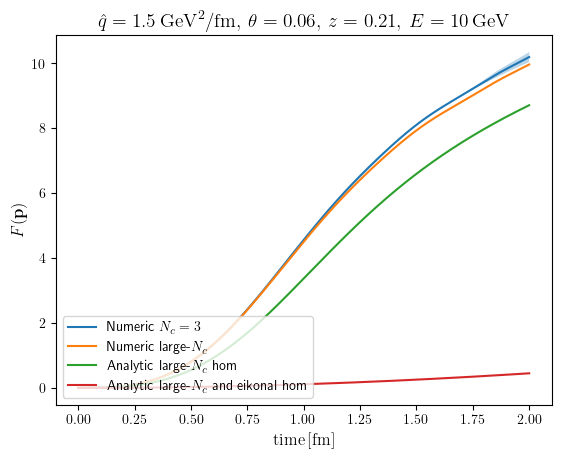

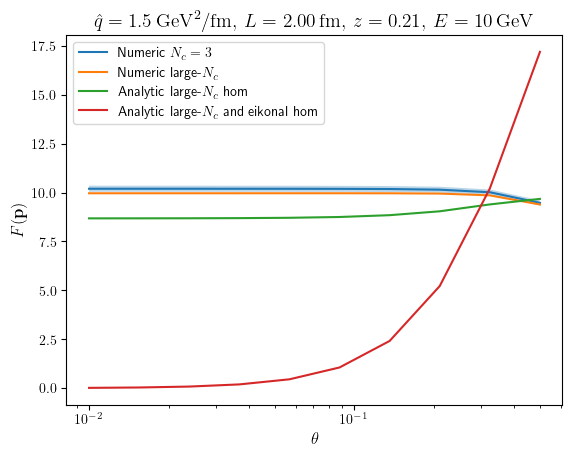

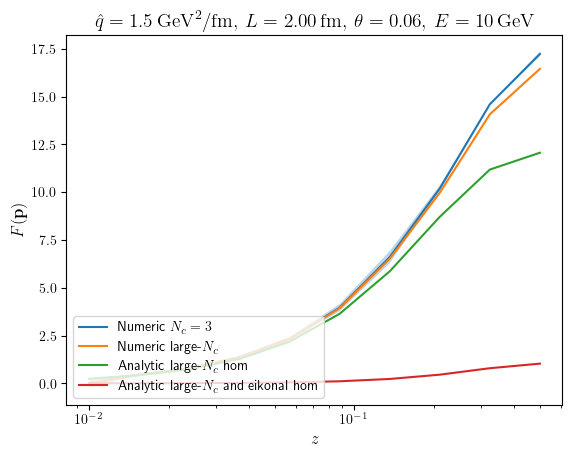

In [430]:
time_frac = 1
z_n=7
theta_n=4

time_plot(z_n,theta_n)
theta_plot(time_frac,z_n)
z_plot(time_frac,theta_n)

In [431]:
time_frac = 1
time_n = int(len(t)*time_frac)-1
time = t[time_n]

Fp_full,Fp_Nc,Fp_diag,Fp_diag_true = Fp(time_frac)

Fp_error_diag_full = abs(Fp_full-Fp_diag)/(1+abs(Fp_full))
Fp_error_Nc_full = abs(Fp_full-Fp_Nc)/(1+abs(Fp_full))
Fp_error_diag = abs(Fp_diag-Fp_diag_true)/(1+abs(Fp_diag_true))

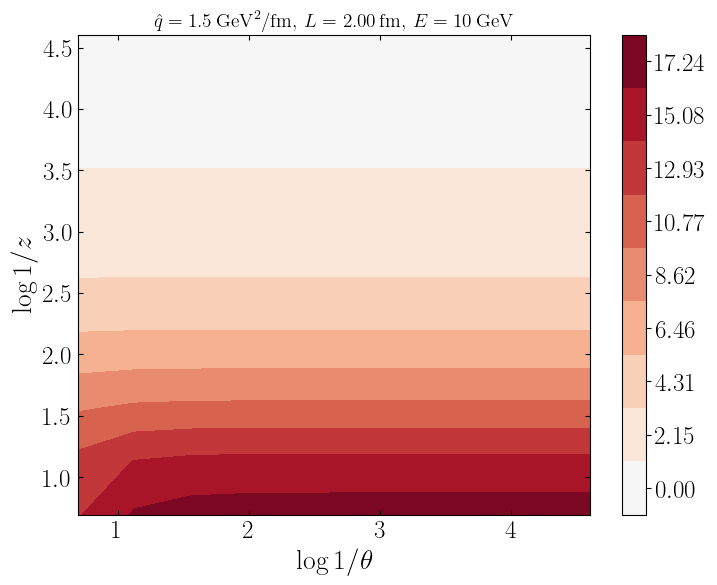

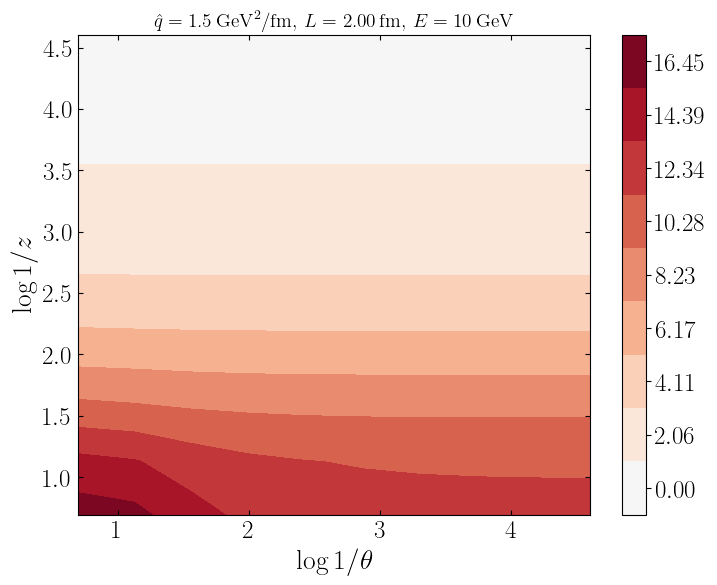

/var/folders/pg/l_nrfrtx4hb_l7x6sdwszd7w0000gn/T/ipykernel_2327/1145586523.py:14: UserWarning: Log scale: values of z <= 0 have been masked
  cp = plt.contourf(TH,Z,zvalues,levels=levels,cmap=plt.get_cmap('YlOrRd'),norm = LogNorm())


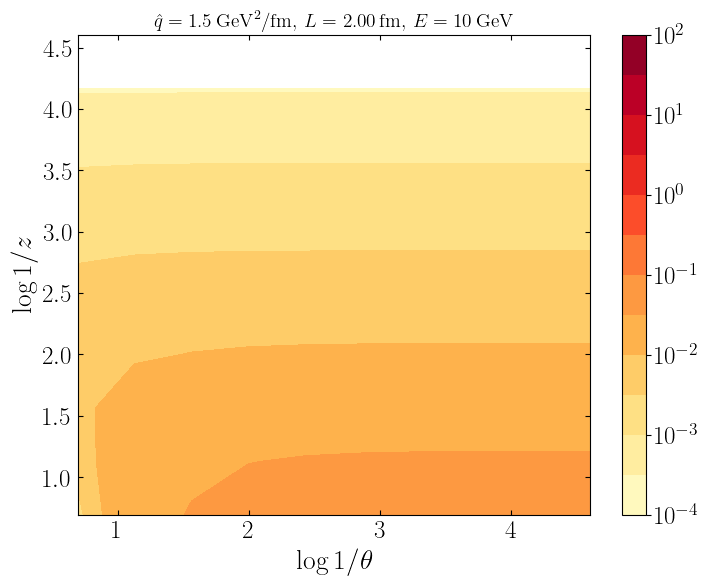

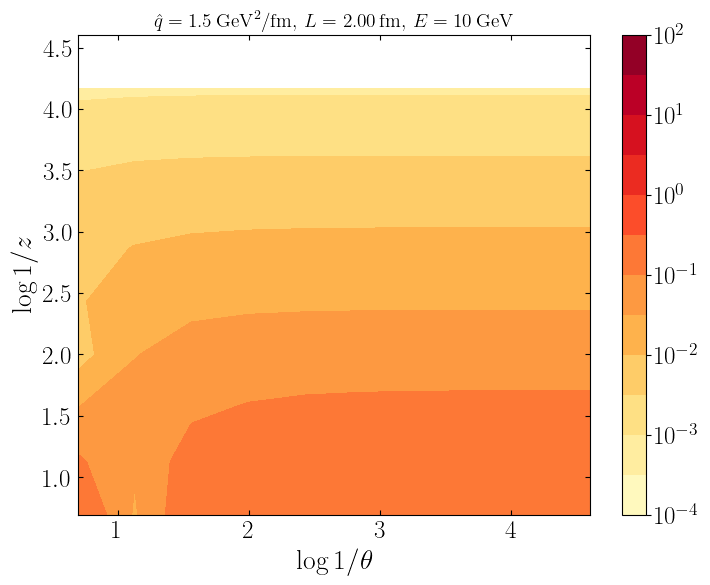

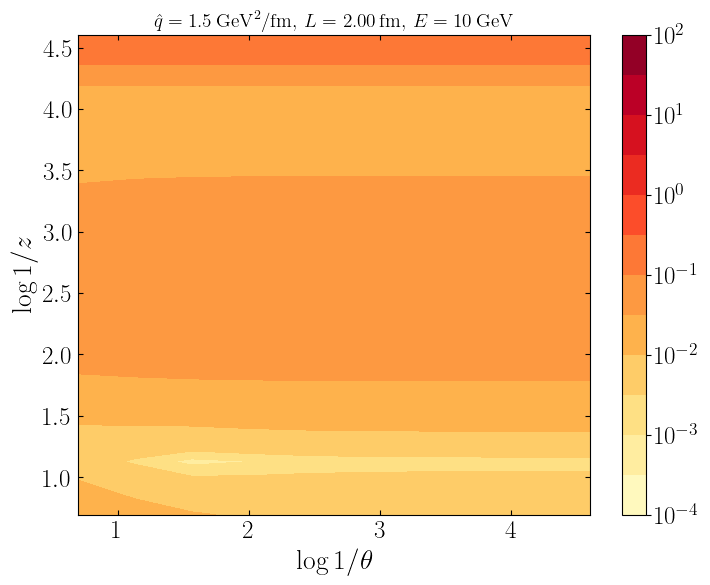

In [432]:
pl(Fp_full,0,time,name='Fp_full')
#pl(Fp_Nc,0,time,name='Fp_Nc')
pl(Fp_diag,0,time,name='Fp_diag')

pl(Fp_error_Nc_full,0,time,log=True)
pl(Fp_error_diag_full,0,time,log=True)
pl(Fp_error_diag,0,time,log=True)

# Fmed

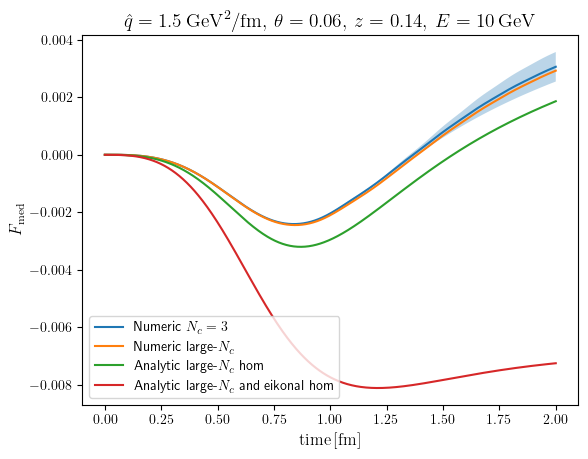

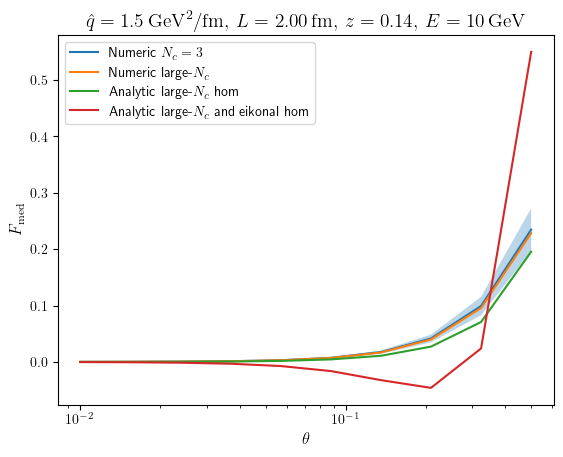

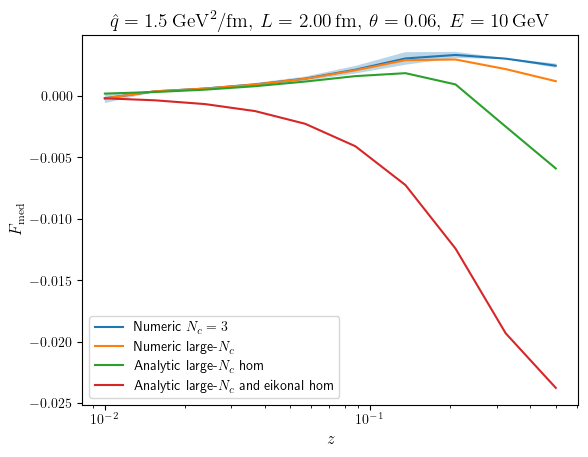

In [433]:
time_frac = 1
z_n=6
theta_n=4

time_plot(z_n,theta_n,Fmed=True)
theta_plot(time_frac,z_n,Fmed=True)
z_plot(time_frac,theta_n,Fmed=True)

In [434]:
time_frac = 1
time_n = int(len(t)*time_frac)-1
time = t[time_n]

Fmed_full,Fmed_Nc,Fmed_diag,Fmed_diag_true = Fmed(time_frac)

Fmed_error_diag_full = abs(Fmed_full-Fmed_diag)/(1+abs(Fmed_full))
Fmed_error_Nc_full = abs(Fmed_full-Fmed_Nc)/(1+abs(Fmed_full))
Fmed_error_diag = abs(Fmed_diag-Fmed_diag_true)/(1+abs(Fmed_diag_true))


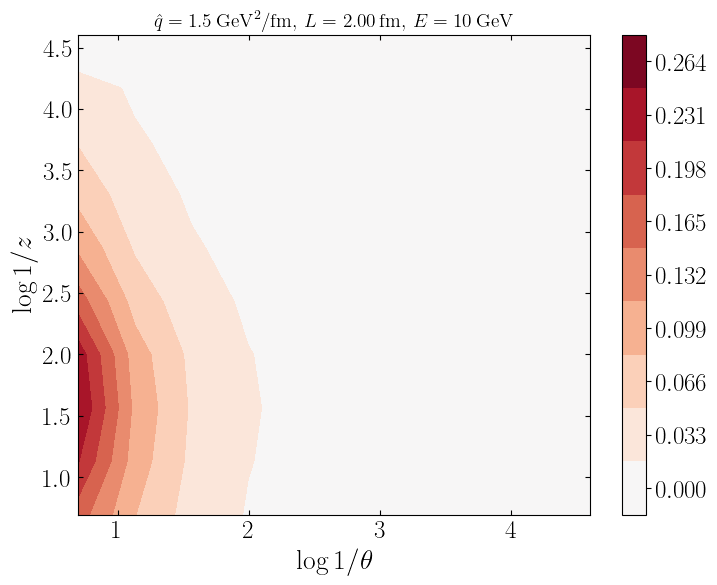

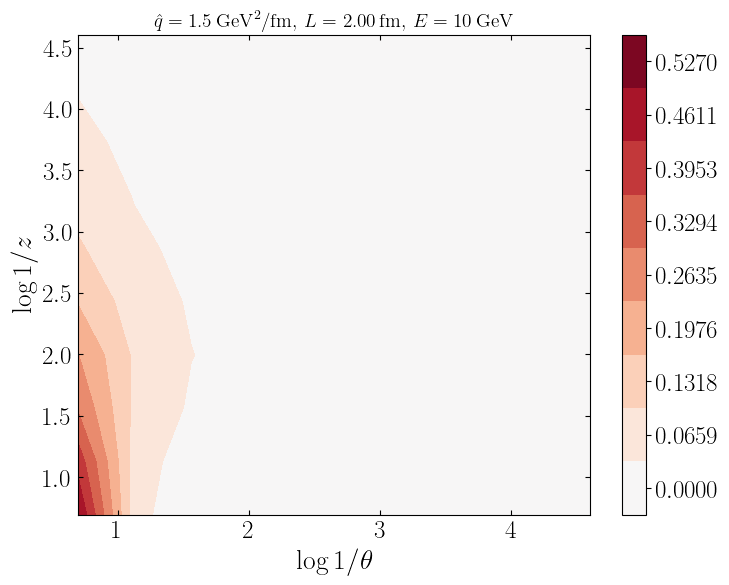

/var/folders/pg/l_nrfrtx4hb_l7x6sdwszd7w0000gn/T/ipykernel_2327/1145586523.py:14: UserWarning: Log scale: values of z <= 0 have been masked
  cp = plt.contourf(TH,Z,zvalues,levels=levels,cmap=plt.get_cmap('YlOrRd'),norm = LogNorm())


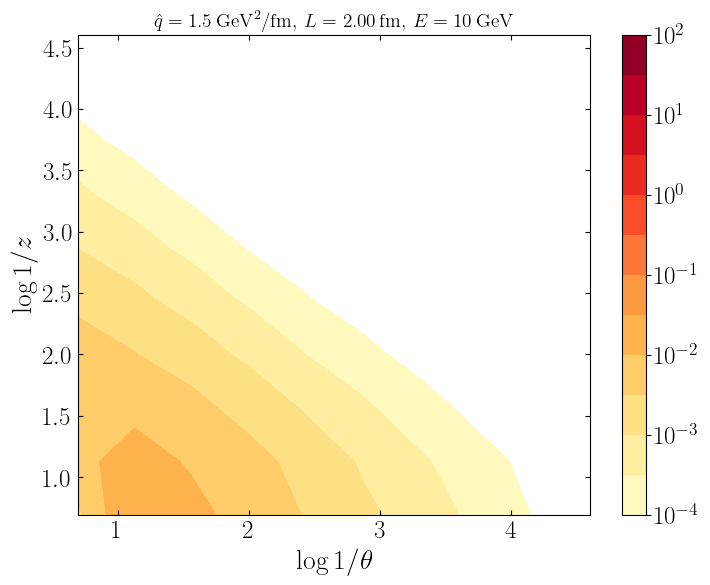

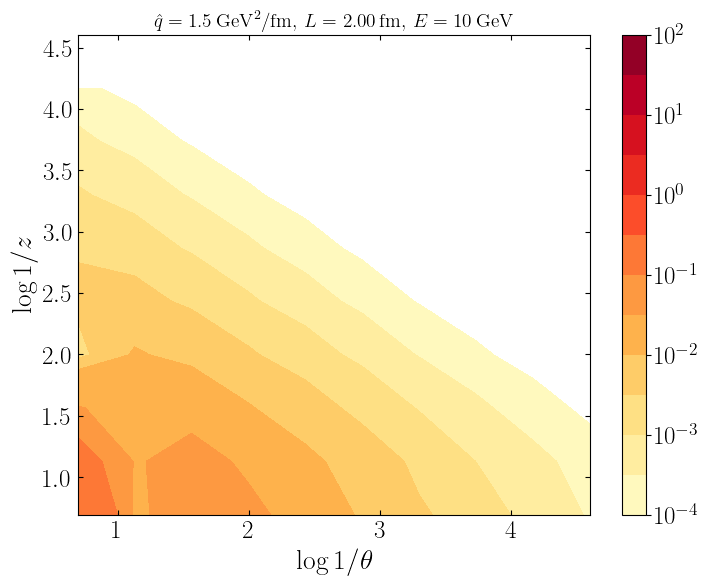

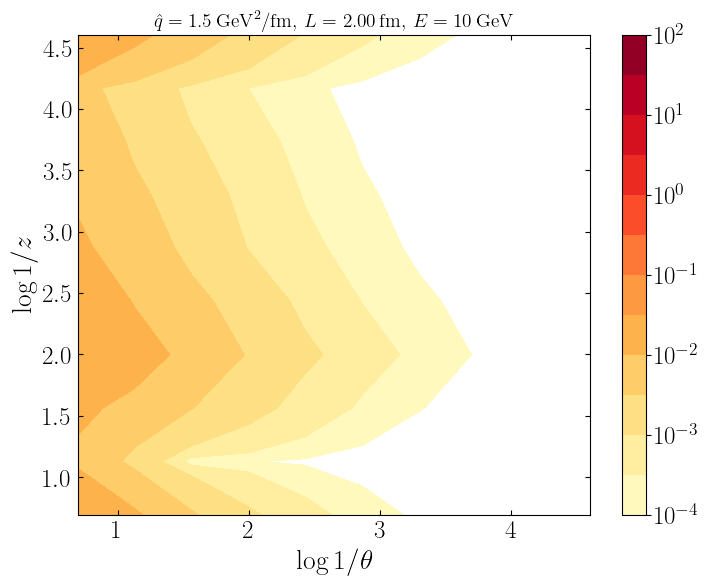

In [435]:
pl(Fmed_full,0,time,name='Fmed_full')
#pl(Fmed_Nc,0,time,name='Fmed_Nc')
pl(Fmed_diag,0,time,name='Fmed_diag')

pl(Fmed_error_Nc_full,0,time,name='Fmed_difference_Nc_full',log=True)
pl(Fmed_error_diag_full,0,time,name='Fmed_difference_diag_full',log=True)
pl(Fmed_error_diag,0,time,name='Fmed_error_diag',log=True)

In [437]:
L=2
z=0.32
th = 0.14
p1=th*w(z)
p2=0

print(w(z))
print(fasit2Ncdiagint(L,p1,p2,z))
print(eik2int(L,z,th))

11.045375999999997
(11.650158778543098-13.684764545178847j)
(4.423984204814552-0.30024278235515106j)
